In [1]:
from m8r import view

In [26]:
%%file 1_train.scons 

import numpy as np
from tensorflow import keras
import m8r

# for reproducibility
from tensorflow import random
np.random.seed(2021)
random.set_seed(2021)

def get_data(target=None,source=None,env=None):
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    # convert class vectors to binary class matrices
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    m8r.File(x_train,name=str(target[0]))
    m8r.File(y_train,name=str(target[1]))
    m8r.File(x_test,name=str(target[2]))
    m8r.File(y_test,name=str(target[3]))
    
Command(['xtrain.rsf','ytrain.rsf','xtest.rsf','ytest.rsf'],None,
       action=Action(get_data))

examples = []
for example in (10010,20010,30010,40010,50010):
    label = 'label%d.txt' % example
    Flow(label,'ytrain',
         '''
         window n2=1 f2=%d | attr want=max | awk \'{ printf(\"title=label:%%d\n\",$$NF-1)}\'
         ''' % example)
    xtrain = 'xtrain%d' % example
    Plot(xtrain,['xtrain',label],
         '''
         window n4=1 f4=%d | 
         grey allpos=y par=${SOURCES[1]} screenratio=1 transp=n wantaxis=n color=I titlesz=24
         ''' % example)
    examples.append(xtrain)
    
Result('train',examples,'SideBySideIso')

Overwriting 1_train.scons


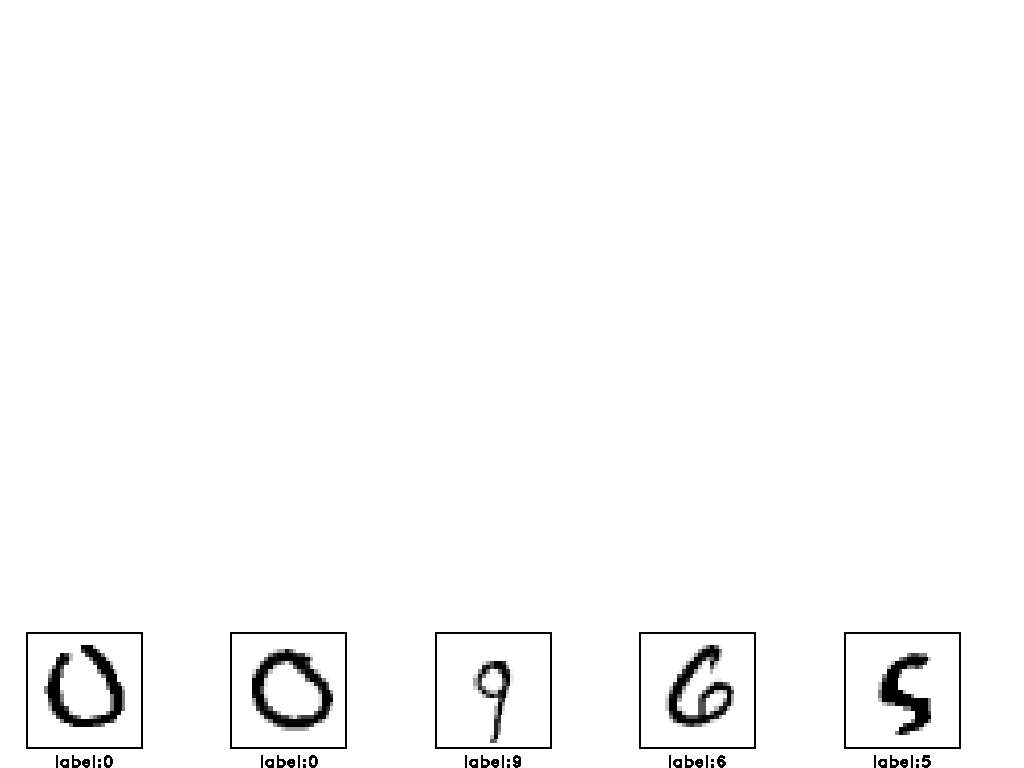

In [27]:
view("train")

In [28]:
%%file 2_test.scons 

from tensorflow.keras import layers

def train_model(target=None,source=None,env=None):
    # define model
    input_shape = (28, 28, 1)
    num_classes = 10
    model = keras.Sequential(
        [
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    # train model
    x_train = m8r.File(str(source[0]))[:]
    y_train = m8r.File(str(source[1]))[:]
    
    batch_size=env.get('batch_size')
    epochs=env.get('epochs')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    
    # save model
    keras.models.save_model(model,str(target[0]),save_format='h5')
        
Command('model.h5',['xtrain.rsf','ytrain.rsf'],action=Action(train_model),
        varlist=['batch_size','epochs'],batch_size=128,epochs=15)

def predict(target=None,source=None,env=None):
    model = keras.models.load_model(str(source[0]))
    x_test = m8r.File(str(source[1]))[:]
    y_pred = model.predict(x_test)
    m8r.File(y_pred,name=str(target[0]))
    
Command('ypred.rsf',['model.h5','xtest.rsf'],action=Action(predict))

examples = []
for example in (110,210,310,410,510):
    label = 'plabel%d.txt' % example
    Flow(label,'ypred',
         '''
         window n2=1 f2=%d | attr want=max | awk \'{ printf(\"title=label:%%d\n\",$$NF-1)}\'
         ''' % example)
    xtest = 'xtest%d' % example
    Plot(xtest,['xtest',label],
         '''
         window n4=1 f4=%d | 
         grey allpos=y par=${SOURCES[1]} screenratio=1 transp=n wantaxis=n color=I titlesz=24
         ''' % example)
    examples.append(xtest)
    
Result('test',examples,'SideBySideIso')

Overwriting 2_test.scons


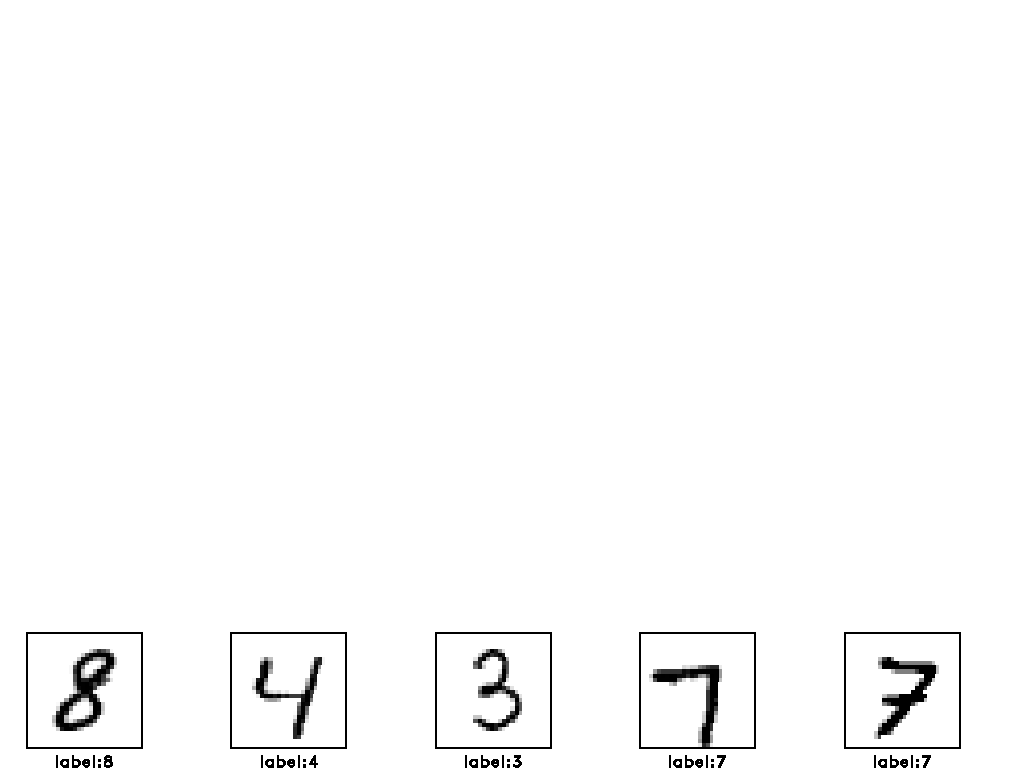

In [29]:
view("test")